In [1]:
import pandas as pd
import numpy as np

# Create dummy data that has dates range from 1 to 100, for each date you have group_ids range from 1 to 100
# Each group_ids has same product type and store location, values, price and discount are random
np.random.seed(42)
data = {
    'time_idx': np.tile(np.arange(1, 101), 100),
    'group_ids': np.repeat(np.arange(1, 101), 100),
    'Product_Type': np.repeat(np.random.choice(['A', 'B', 'C', 'D'], size=100), 100),
    'value': np.random.randint(1, 100, size=10000),
    'Price': np.random.uniform(10, 100, size=10000),
    'Discount': np.random.uniform(0, 0.5, size=10000),
    'Store_Location': np.repeat(np.random.choice(['North', 'South', 'East', 'West'], size=100), 100)
}


# Create DataFrame
df = pd.DataFrame(data)


In [2]:
# %pip install pytorch-forecasting

from pytorch_forecasting import TimeSeriesDataSet

max_encoder_length = 30
max_prediction_length = 10

# Use the df DataFrame instead of data dictionary
training_cutoff = df["time_idx"].max() - max_prediction_length


# Create training dataset
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["group_ids"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Product_Type", "Store_Location"],
    time_varying_known_reals=["time_idx", "Price", "Discount"],
    time_varying_unknown_reals=["value"],
)

# Create validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training, df, predict=True, stop_randomization=True
)

# Create DataLoaders
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)

d:\softwares\Anaconda\envs\yolo\lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 68.1k


Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 20.43it/s]
Learning rate set to 0.07567484748311692
Restoring states from the checkpoint path at d:\yzhao\Documents\stock_optimization\.lr_find_02a661cd-400d-45ed-91cf-dd2dcbdd34fd.ckpt
Restored all states from the checkpoint at d:\yzhao\Documents\stock_optimization\.lr_find_02a661cd-400d-45ed-91cf-dd2dcbdd34fd.ckpt


suggested learning rate: 0.07567484748311692


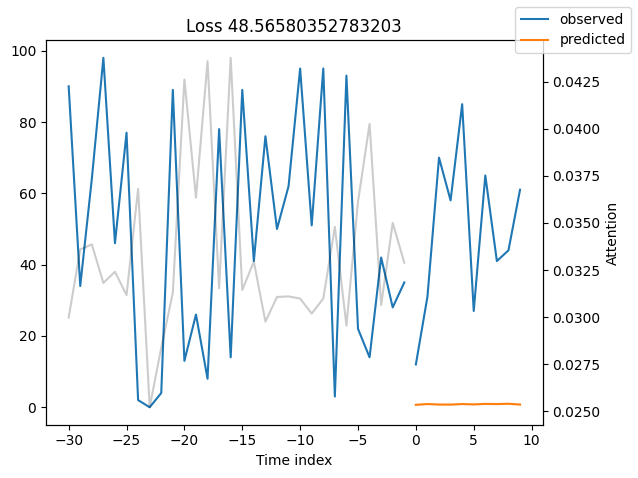

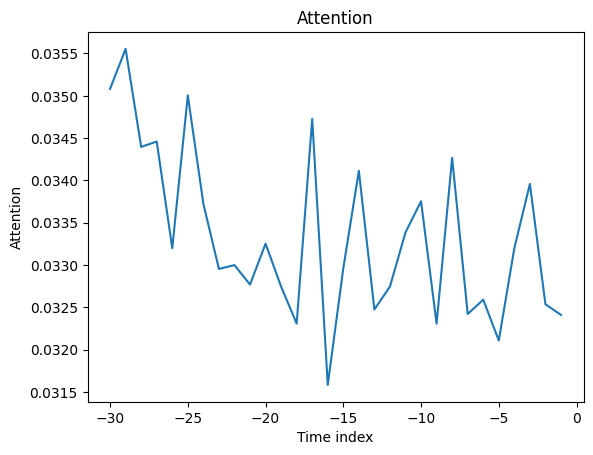

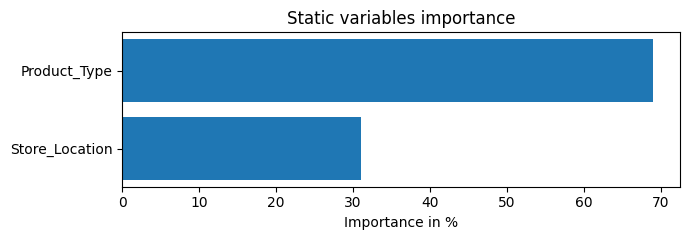

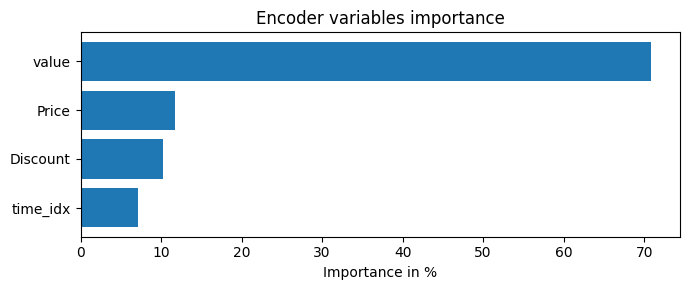

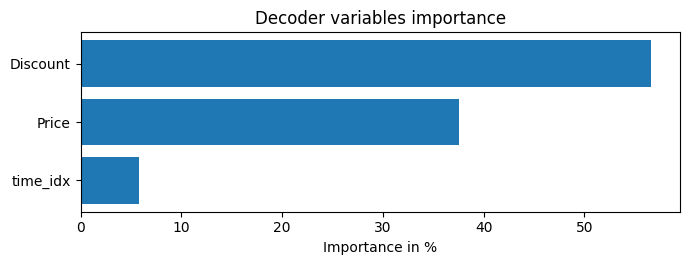

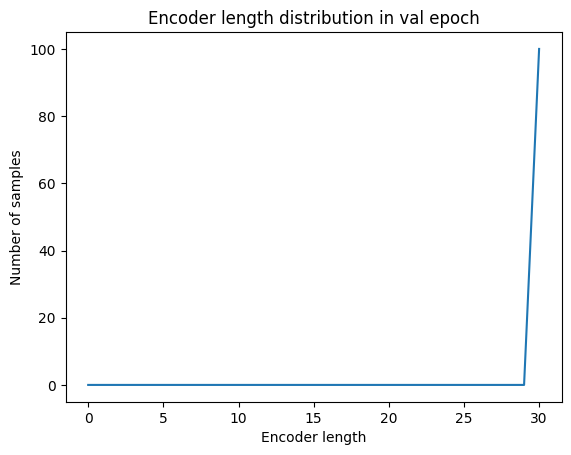

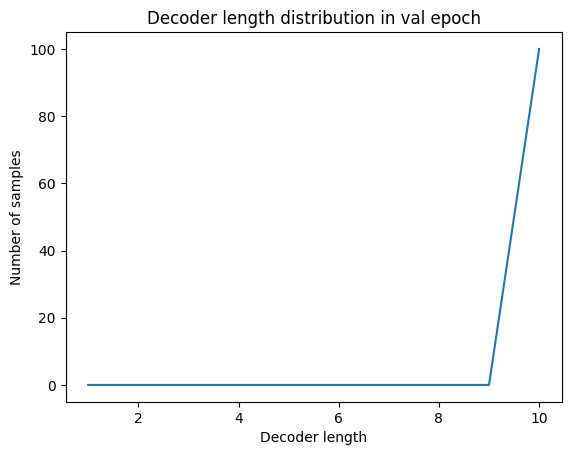

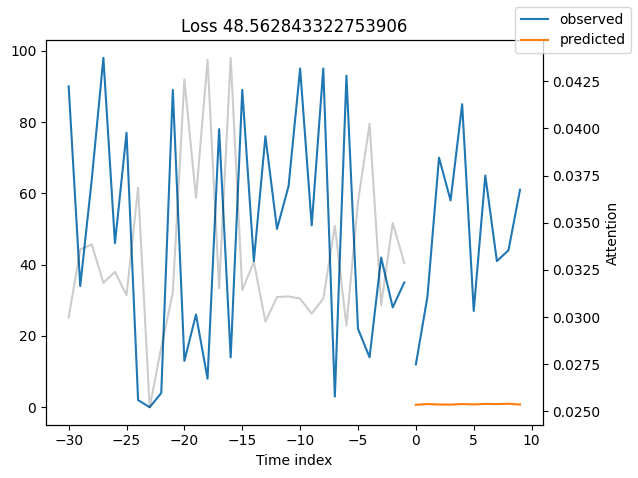

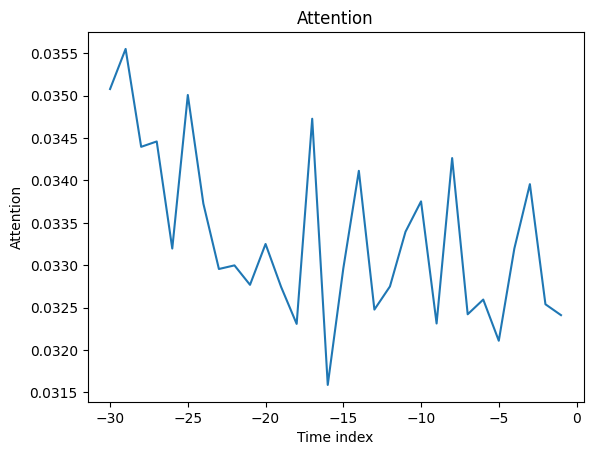

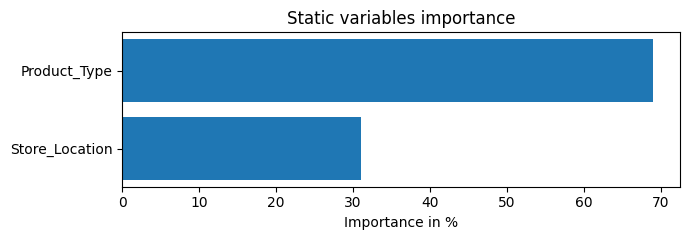

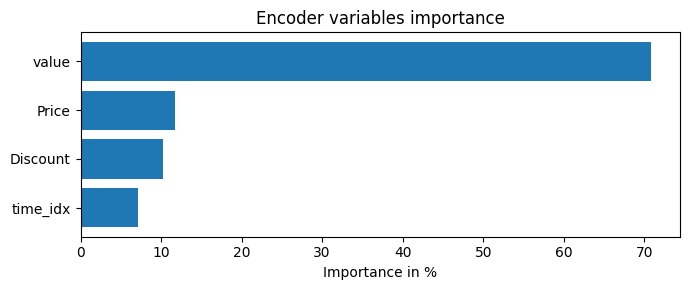

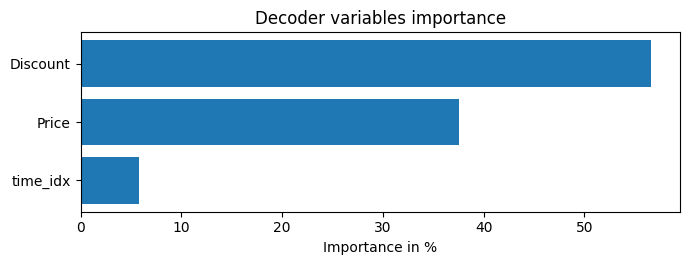

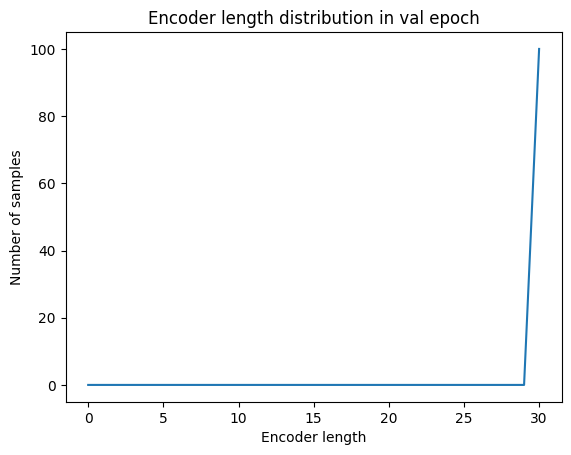

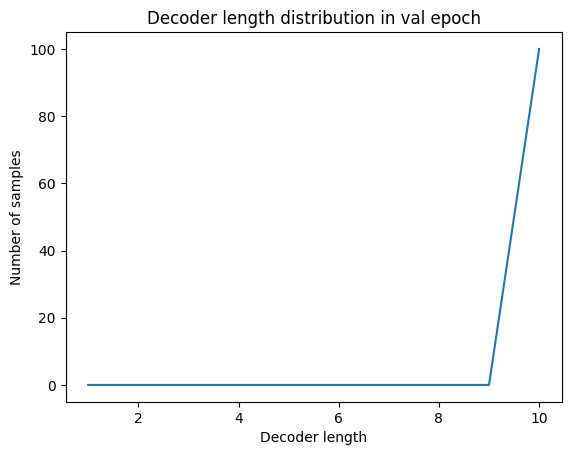

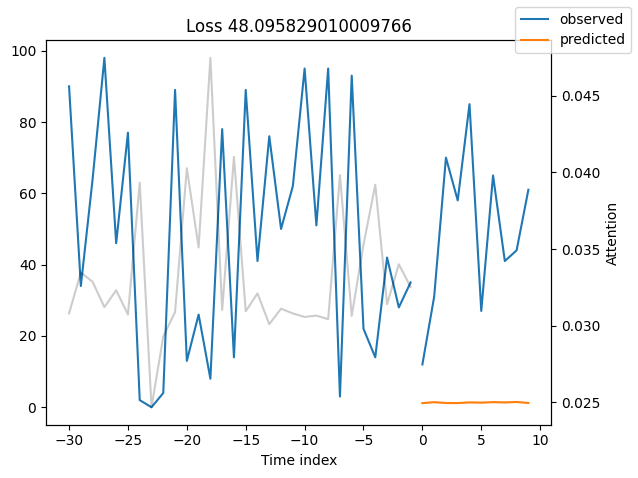

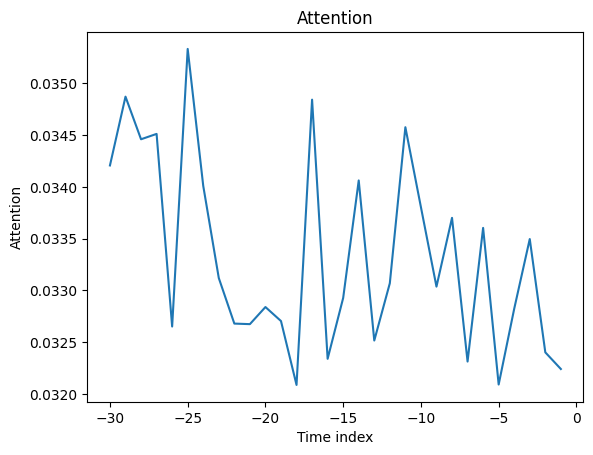

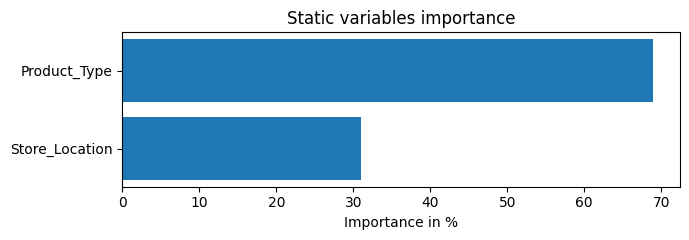

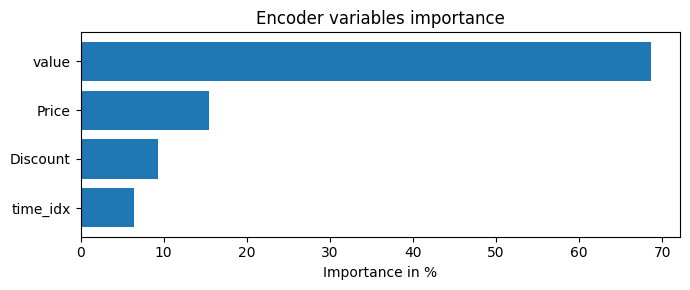

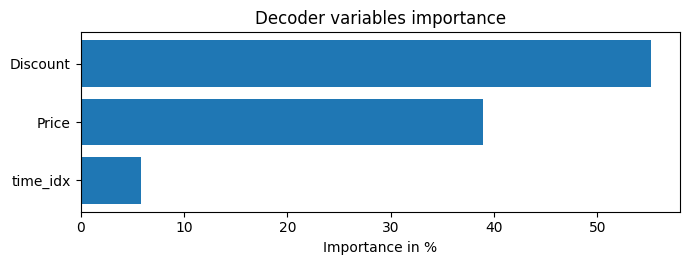

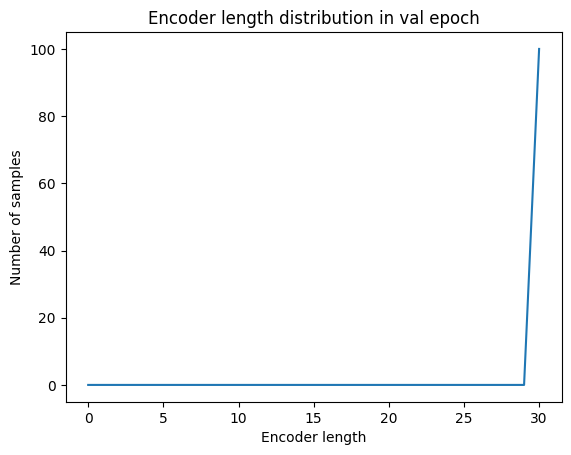

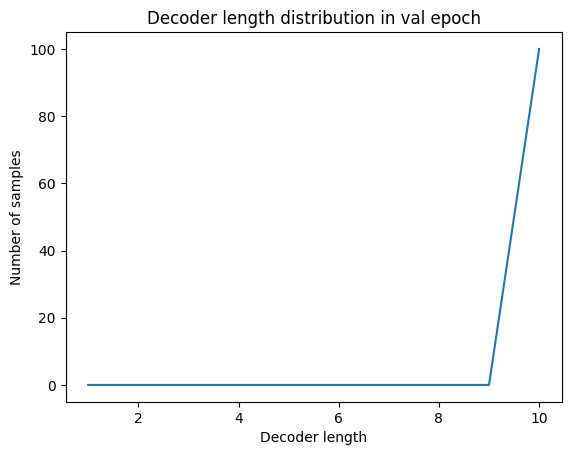

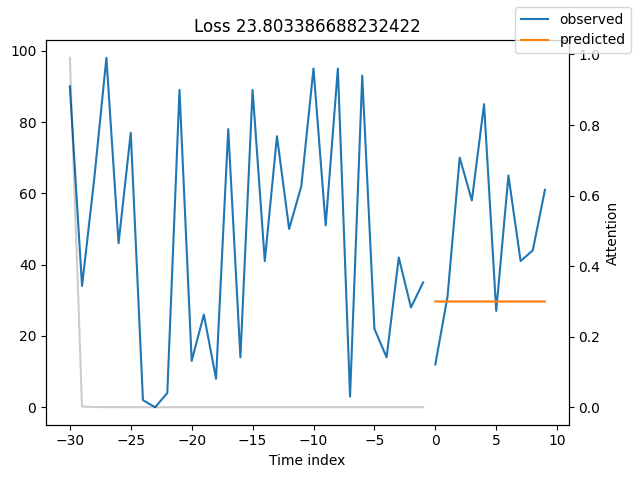

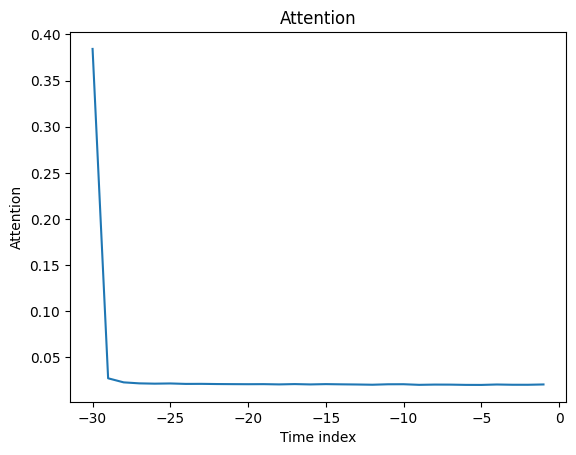

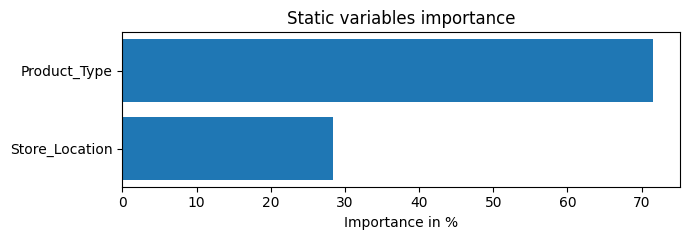

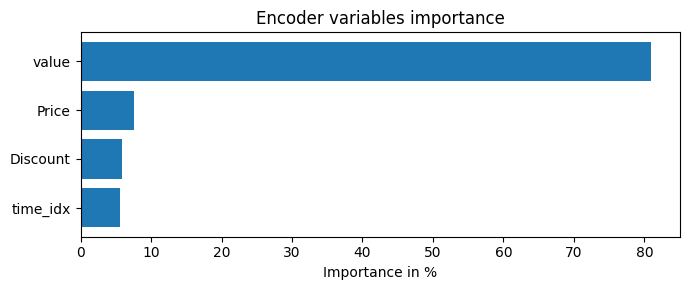

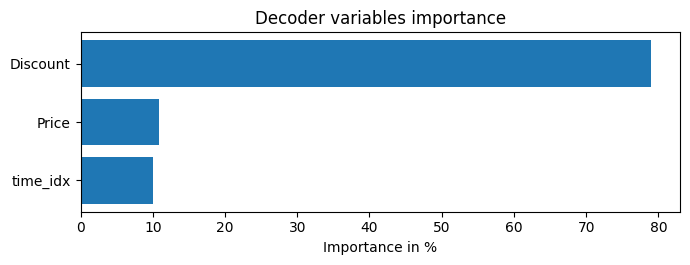

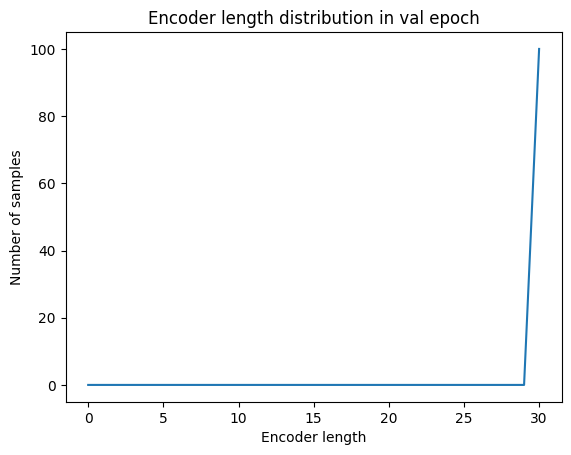

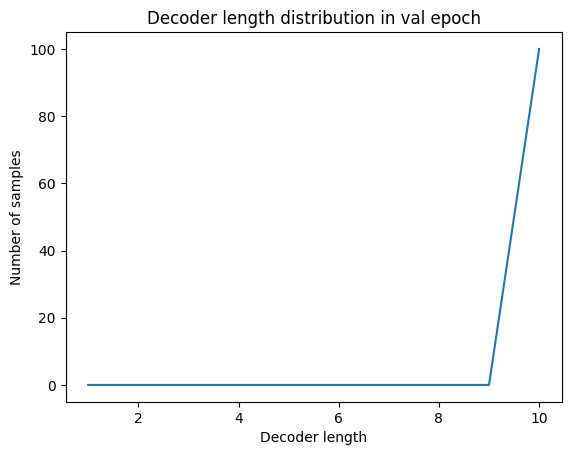

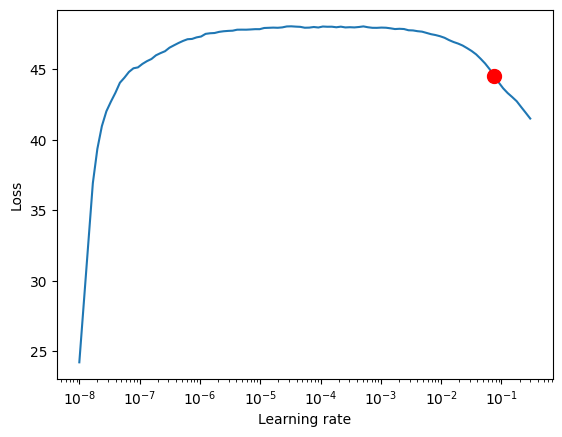

C:\Users\y zhao\AppData\Local\Temp\ipykernel_15860\2837492579.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 24     | train
3  | prescalers                         | ModuleDict                      | 128    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 234    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.8 K  | train


Epoch 1: 100%|██████████| 30/30 [00:01<00:00, 17.48it/s, v_num=7, train_loss_step=24.50, val_loss=24.60, train_loss_epoch=25.00]


In [13]:
#%pip install tensorboard

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss, MAE

# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
# Initialize TensorBoard logger
logger = TensorBoardLogger("lightning_logs", name="my_model")
# Initialize LearningRateMonitor
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


# create the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=1,
    loss=MAE(),
    log_interval=2,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)